<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#I-made-an-ims_iter-so-I-can-rapidly-ctrl+enter-through-next(ims_iter)-like-a-flip-book." data-toc-modified-id="I-made-an-ims_iter-so-I-can-rapidly-ctrl+enter-through-next(ims_iter)-like-a-flip-book.-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>I made an ims_iter so I can rapidly ctrl+enter through next(ims_iter) like a flip book.</a></span></li><li><span><a href="#These-are-the-labels.-They-appear-to-contain-three-x,y,z-keypoints,-and-one-other-x,y,z." data-toc-modified-id="These-are-the-labels.-They-appear-to-contain-three-x,y,z-keypoints,-and-one-other-x,y,z.-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>These are the labels. They appear to contain three x,y,z keypoints, and one other x,y,z.</a></span></li><li><span><a href="#Calibration-files-for-depth-and-rgb." data-toc-modified-id="Calibration-files-for-depth-and-rgb.-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Calibration files for depth and rgb.</a></span></li><li><span><a href="#Given-an-im-path,-produce-the-text-file-containing-its-label" data-toc-modified-id="Given-an-im-path,-produce-the-text-file-containing-its-label-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Given an im path, produce the text file containing its label</a></span></li><li><span><a href="#Given-an-im-path,-produce-its-label-tensor" data-toc-modified-id="Given-an-im-path,-produce-its-label-tensor-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Given an im path, produce its label tensor</a></span></li><li><span><a href="#data-block" data-toc-modified-id="data-block-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>data block</a></span></li><li><span><a href="#Train" data-toc-modified-id="Train-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Train</a></span></li></ul></div>

In [ ]:
from fastai.vision.all import *

In [ ]:
path = untar_data(URLs.BIWI_HEAD_POSE)

In [ ]:
Path.BASE_PATH = path

In [ ]:
path.ls()

(#50) [Path('14'),Path('17.obj'),Path('16.obj'),Path('08.obj'),Path('21.obj'),Path('18'),Path('11.obj'),Path('04.obj'),Path('06.obj'),Path('03')...]

In [ ]:
(path/'14').ls().sorted()

(#1596) [Path('14/depth.cal'),Path('14/frame_00003_pose.txt'),Path('14/frame_00003_rgb.jpg'),Path('14/frame_00004_pose.txt'),Path('14/frame_00004_rgb.jpg'),Path('14/frame_00005_pose.txt'),Path('14/frame_00005_rgb.jpg'),Path('14/frame_00006_pose.txt'),Path('14/frame_00006_rgb.jpg'),Path('14/frame_00007_pose.txt')...]

In [ ]:
path.parent,path.name

(Path('/home/rory/.fastai/data'), 'biwi_head_pose')

##### I made an ims_iter so I can rapidly ctrl+enter through next(ims_iter) like a flip book.

In [ ]:
ims = get_image_files(path).sorted()
ims_iter = iter(ims)
len(ims)

15678

/home/rory/.fastai/data/biwi_head_pose/01/frame_00003_rgb.jpg


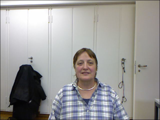

In [ ]:
next_im = next(ims_iter)
print(next_im)
im = PILImage.create(next_im).to_thumb(160)
im

##### These are the labels. They appear to contain three x,y,z keypoints, and one other x,y,z.

In [ ]:
!cat '/home/rory/.fastai/data/biwi_head_pose/14/frame_00003_pose.txt'

0.999884 0.00399683 -0.0147057 
-0.00332519 0.998963 0.0454161 
0.0148719 -0.045362 0.99886 

56.6861 14.9852 879.29 



##### Calibration files for depth and rgb.

In [ ]:
!cat '/home/rory/.fastai/data/biwi_head_pose/14/depth.cal'

575.816 0 320 
0 575.816 240 
0 0 1 

0 0 0 0 

1 0 0 
0 1 0 
0 0 1 

0 0 0 

640 480


In [ ]:
!cat '/home/rory/.fastai/data/biwi_head_pose/14/rgb.cal'

517.679 0 320 
0 517.679 240.5 
0 0 1 

0 0 0 0 

0.999947 0.00432361 0.00929419 
-0.00446314 0.999877 0.0150443 
-0.009228 -0.015085 0.999844 

-24.0198 5.8896 -13.2308 

640 480


##### Given an im path, produce the text file containing its label

In [ ]:
def img2pose(x): return Path(f'{str(x)[:-7]}pose.txt') # 'rgb.jpg' → 'pose.txt'

##### Given an im path, produce its label tensor

In [ ]:
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6) # calibrate all sequences to 01

def get_ctr(fn):
    ctr = np.genfromtxt(img2pose(fn), skip_header=3)
    c1 = ctr[0] * cal[0][0]/ctr[2] + cal[0][2]
    c2 = ctr[1] * cal[1][1]/ctr[2] + cal[1][2]
    return tensor([c1,c2])

In [ ]:
f_ex = '/home/rory/.fastai/data/biwi_head_pose/14/frame_00003_rgb.jpg'

In [ ]:
!cat '/home/rory/.fastai/data/biwi_head_pose/14/frame_00003_pose.txt'

0.999884 0.00399683 -0.0147057 
-0.00332519 0.998963 0.0454161 
0.0148719 -0.045362 0.99886 

56.6861 14.9852 879.29 



In [ ]:
!cat '/home/rory/.fastai/data/biwi_head_pose/01/rgb.cal'

517.679 0 320 
0 517.679 240.5 
0 0 1 

0 0 0 0 

0.999947 0.00432361 0.00929419 
-0.00446314 0.999877 0.0150443 
-0.009228 -0.015085 0.999844 

-24.0198 5.8896 -13.2308 

640 480


In [ ]:
cal

array([[517.679,   0.   , 320.   ],
       [  0.   , 517.679, 240.5  ],
       [  0.   ,   0.   ,   1.   ]])

In [ ]:
get_ctr(Path(f_ex))

tensor([353.3737, 249.3225])

Looking inside get_ctr...

In [ ]:
ctr = np.genfromtxt(img2pose(f_ex), skip_header=3); ctr

array([ 56.6861,  14.9852, 879.29  ])

In [ ]:
c1 = ctr[0] * cal[0][0]/ctr[2] + cal[0][2]; c1

353.37374877674034

In [ ]:
ctr[0]

56.6861

In [ ]:
c2 = ctr[1] * cal[1][1]/ctr[2] + cal[1][2]; c2

249.32248558587042

##### data block

In [ ]:
db = DataBlock(
    blocks=(ImageBlock, PointBlock),
    get_items=get_image_files,
    get_y=get_ctr,
    splitter=FuncSplitter(lambda itm: itm.parent.name=='13'),
    batch_tfms=[*aug_transforms(size=(240,320)),
                Normalize.from_stats(*imagenet_stats)]
)

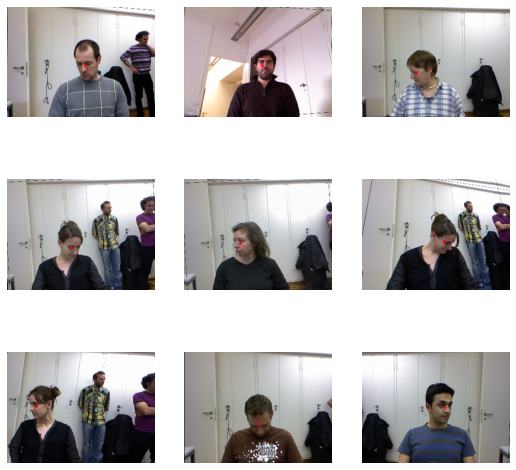

In [ ]:
dls = db.dataloaders(path)
dls.show_batch(max_n=9)

In [ ]:
xb,yb = dls.one_batch()
xb.shape, yb.shape

(torch.Size([64, 3, 240, 320]), torch.Size([64, 1, 2]))

##### Train

In [ ]:
learner = cnn_learner(dls, resnet18, y_range=(-1,1))

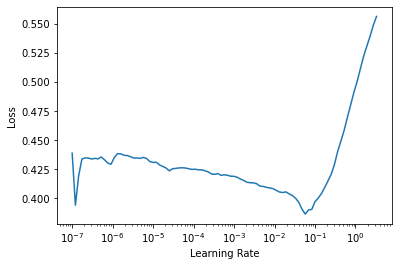

In [ ]:
lr_min,lr_steep = learner.lr_find()

In [ ]:
lr = (lr_min+lr_steep)/2

*`fine_tune(3,lr)` will train the new output layer one epoch and then everything together 3 epochs.*

In [ ]:
learner.fine_tune(3,lr)

epoch,train_loss,valid_loss,time
0,0.051676,0.008322,00:26


epoch,train_loss,valid_loss,time
0,0.005004,0.000483,00:34
1,0.001787,0.000282,00:34
2,0.001186,0.000038,00:34


In [ ]:
math.sqrt(0.000483), math.sqrt(0.000282), math.sqrt(0.000038)

(0.02197726097583591, 0.016792855623746664, 0.006164414002968977)

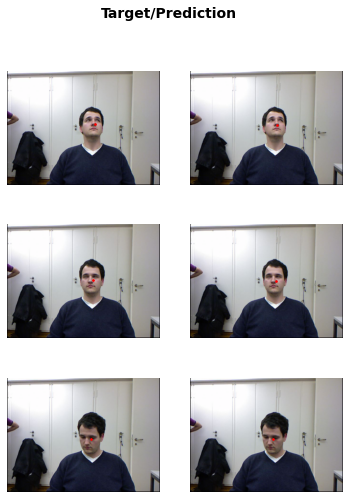

In [ ]:
learner.show_results(ds_idx=1, figsize=(6,8))